Notebook to collect the information of the generation

### Import

In [1]:
import sys, os, re, yaml, pickle
import commands
from glob import glob
from prettytable import PrettyTable
sys.path.append('../lib')

import time, datetime

In [2]:
import signal

class TimeoutError(Exception):
    pass

class timeout:
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message
    def handle_timeout(self, signum, frame):
        raise TimeoutError(self.error_message)
    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)
    def __exit__(self, type, value, traceback):
        signal.alarm(0)

# with timeout(seconds=1):
#     try:
#         time.sleep(2)
#     except TimeoutError:
#         print 'Got it'

In [3]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from progressBar import ProgressBar

In [4]:
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

Welcome to JupyROOT 6.12/07


In [5]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Lumis
from DataFormats.FWLite import Handle
# import commands

In [6]:
from analysis_utilities import DSetLoader

# Inputs

Max 3 dataset per time otherwise run out of memory

In [7]:
inDic = {}

In [8]:
# inDic['muHQET_0'] = DSetLoader('B0_MuNuDmst_HQETcentral_PU0')
# inDic['mu_0'] = DSetLoader('B0_MuNuDmst_PU0')
# inDic['mu_20'] = DSetLoader('B0_MuNuDmst_PU20')
inDic['mu_c0'] = DSetLoader('B0_MuNuDmst_PUc0')
# inDic['mu_35'] = DSetLoader('B0_MuNuDmst_PU35')

# inDic['tau_0'] = DSetLoader('B0_TauNuDmst_PU0')
# inDic['tau_20'] = DSetLoader('B0_TauNuDmst_PU20')
inDic['tau_c0'] = DSetLoader('B0_TauNuDmst_PUc0')
# inDic['tau_35'] = DSetLoader('B0_TauNuDmst_PU35')

# inDic['Hc_20'] = DSetLoader('B0_DmstHc_PU20')
inDic['Hc_c0'] = DSetLoader('B0_DmstHc_PUc0')

# inDic['DstPip_20'] = DSetLoader('Bp_MuNuDstst_PU20')
inDic['DstPip_c0'] = DSetLoader('Bp_MuNuDstst_Pip_PUc0')

inDic['DstPi0_c0'] = DSetLoader('B0_MuNuDstst_Pi0_PUc0')

inDic['DstPi0nR_c0'] = DSetLoader('B0_DmstPi0MuNu_PUc0')

inDic['DststPipPi0_c0'] = DSetLoader('Bp_MuNuDstst_PipPi0_PUc0')

inDic['DststPipPim_c0'] = DSetLoader('B0_MuNuDstst_PipPim_PUc0')

inDic['DststPi0Pi0_c0'] = DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0')

CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.
CAND efficiency file missing.


In [9]:
# inDic['mu_0'] = DSetLoader('B0_MuNuDmst_PU0', candDir='ntuples_probeB2DstMu')
# inDic['p_mu_c0'] = DSetLoader('p_B0_MuNuDst_PUc0', candDir='ntuples_probeB2DstMu')
# inDic['p_tau_c0'] = DSetLoader('p_B0_TauNuDst_PUc0', candDir='ntuples_probeB2DstMu')

In [10]:
# inDic['JPsiKst_0'] = DSetLoader('B0_JpsiKst_PU0', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_20'] = DSetLoader('B0_JpsiKst_PU20', candDir='ntuples_B2JpsiKst')
# inDic['JPsiKst_35'] = DSetLoader('B0_JpsiKst_PU35', candDir='ntuples_B2JpsiKst')

# inDic['JPsiKstFSR_20'] = DSetLoader('B0_JpsiKstFSR_PU20', candDir='ntuples_B2JpsiKst')

# Efficiency

In [11]:
def getEff(k,N):
    e = k/float(N)
    de = np.sqrt(e*(1-e)/N)
    return [e, de]

## Generator Efficiency

In [12]:
handle = {}
handle['genFilter'] = [Handle('GenFilterInfo'), ('genFilterEfficiencyProducer', '', 'SIM')]
handle['genProduct'] = [Handle('GenLumiInfoProduct'), ('generator', '', 'SIM')]

In [13]:
def analyzeMINIAODs(fileList):  
    print 'Analizing', len(fileList), 'MINIAOD'
    N_gen = 0
    N_cuts = 0
    xsec = []
    xsec_err = []
    pb = ProgressBar(maxEntry=len(fileList))
    skippedFiles = []
    for i_j, fileName in enumerate(fileList):
        pb.show(i_j)
        with timeout(seconds=1):
            try:
#                 cmd = 'python generatorEfficiency_MINIAODSIM.py ' + fileName
#                 status, output = commands.getstatusoutput(cmd)
#                 aux = output.split(' ')
#                 N_gen += float(aux[0])
#                 N_cuts += float(aux[1])
#                 xsec.append(float(aux[2]))
#                 xsec_err.append(float(aux[4]))
                for lumi in Lumis(fileName):
                    prods = {}
                    for k,v in handle.iteritems():
                        lumi.getByLabel(v[1], v[0])
                        prods[k] = v[0].product()
                    N_cuts += prods['genFilter'].numEventsPassed()
                    N_gen += prods['genFilter'].numEventsTotal()
                    xs = prods['genProduct'].getProcessInfos()[0].lheXSec()
                    xsec.append(xs.value())
                    xsec_err.append(xs.error())
            except TimeoutError:
                skippedFiles.append(fileName)
    print 'Skipped {} files'.format(len(skippedFiles))
    print 'Total events in analyzed MINIAODs', N_cuts
    xsec = np.array(xsec)
    xsec_err = np.array(xsec_err)
    return N_gen, N_cuts, xsec, xsec_err

In [14]:
N_max = 1000
recreate = []#inDic.keys()
for n, d in inDic.iteritems():
    print '\n\n--> ' + d.sample
    
    outdir = os.path.join(d.candLoc, d.full_name)
    outyamlFile = os.path.join(outdir,'effMCgenerator.yaml')
    if os.path.isfile(outyamlFile) and not n in recreate:
        print 'Already present'
        dic = yaml.load(open(outyamlFile, 'r'))
        print dic
        continue
        
    fileList = []
    for directory in d.MINIAOD_dirs:
        fileList += glob(directory + '/out_MINIAODSIM_*.root')
    if N_max > 0 and N_max < len(fileList):
        fileList = np.random.choice(fileList, N_max)
    
    N_gen, N_cuts, xsec, xsec_err = analyzeMINIAODs(fileList)
    s2 = np.square(xsec_err)
    num = np.sum(xsec/s2)
    den = np.sum(1./s2)
    xsec = 1e3*num/den
    xsec_err = 1e3*np.sqrt(1/den)
    print 'Xsec: {:1.4e} +/- {:1.4e} fb ({:1.1e})'.format(xsec, xsec_err, xsec_err/xsec)
    d.xsec = [xsec, xsec_err]
    
    e, de = getEff(N_cuts, N_gen)
    print 'eff generator: {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    d.effGEN = [e, de]

    dump_dic = {}
    for k in ['xsec', 'effGEN']:
        aux = getattr(d, k)
        dump_dic[k] = [float(aux[0]), float(aux[1])]
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    with open(outyamlFile, 'w') as dumpF:
        dumpF.write(yaml.dump(dump_dic, default_flow_style=False, default_style=''))



--> Bp_MuNuDstst_Pip_PUc0
Already present
{'xsec': [148782981285.01956, 5108822.576785716], 'effGEN': [0.0016565986003406958, 2.897362371610159e-06]}


--> B0_MuNuDstst_Pi0Pi0_PUc0
Already present
{'xsec': [148774360736.96924, 5161460.982964977], 'effGEN': [0.0016583937823834197, 2.928901465576616e-06]}


--> B0_DmstHc_PUc0
Already present
{'xsec': [148788469794.0802, 4163810.500592461], 'effGEN': [0.0004763674093172517, 1.267036162113285e-06]}


--> B0_DmstPi0MuNu_PUc0
Already present
{'xsec': [148780311350.5397, 5116770.189082066], 'effGEN': [0.001888940565589403, 3.098326708691149e-06]}


--> B0_TauNuDmst_PUc0
Already present
{'xsec': [148775889413.01022, 5150860.645516099], 'effGEN': [0.0008566460268317854, 2.1015402779430175e-06]}


--> B0_MuNuDstst_PipPim_PUc0
Already present
{'xsec': [148785953669.81827, 5156584.266472042], 'effGEN': [0.0016565818506610963, 2.9242836912310112e-06]}


--> B0_MuNuDstst_Pi0_PUc0
Analizing 1000 MINIAOD
[####################]  100% - Tot. time: 181

## ntuplizer efficiency

In [15]:
for d in inDic.values():
    print '\n\n--> ' + d.sample

    if not os.path.isdir(d.ntuples_dir):
        continue
    cand_out_list = glob(os.path.join(d.ntuples_dir,'out/job*.out'))
    N_analyzed = 0
    N_trg = 0
    N_cand = 0
    print 'Analyzing {} ntuplizer job logs'.format(len(cand_out_list))
    pb = ProgressBar(maxEntry=len(cand_out_list))
    for ic, cand_out in enumerate(cand_out_list):
        pb.show(ic)
        eff_ln = []
        counters = []
        takingCounters = False
        for line in open(cand_out).readlines():
            if 'efficiency:' in line:
                eff_ln.append(line)
            elif 'counters:' in line:
                    takingCounters = True
            elif takingCounters and line[:-1].isdigit():
                counters.append(int(line[:-1]))
            elif takingCounters:
                takingCounters = False

        aux = re.search('[0-9]+/[0-9]+', eff_ln[0]).group(0)
        aux = aux.split('/')
        N_analyzed += int(aux[1])
        N_trg += int(aux[0])
        
        aux = re.search(': [0-9]+/', eff_ln[1]).group(0)
        N_cand += int(aux[2:-1])
        
        counters=np.array(counters)
        if not hasattr(d, 'counters'):
            d.counters = counters
        else:
            d.counters += counters
        
    d.nTotMINIAOD = N_analyzed
    d.nTotCAND = N_cand
    print 'Total MINIAOD:', N_analyzed
    print 'Total candidates:', N_cand
    
    e, de = getEff(N_trg, N_analyzed)
    d.effCAND_trg = e, de
    print 'eff candidates (trigger): {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    
    e, de = getEff(N_cand, N_trg)
    d.effCAND_cand = e, de
    print 'eff candidates (cand): {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    
    e, de = getEff(N_cand, N_analyzed)
    d.effCAND = e, de
    print 'eff candidates: {:1.3e} +/- {:1.3e} ({:1.1e})'.format(e,de, de/e)
    
    print 'Getting the total rates (if existing)'
    try:
        fCandLoc = glob(os.path.join(d.ntuples_dir,'out_CAND_*.root'))[0]
        fCand = ur.open(fCandLoc)
        Trate = fCand['p']['Trate']
        d.rate = {}
        for k in Trate.keys():
            r = Trate.array(k)[0]
            r *= 1e12 #GeV -> meV
            d.rate[str(k)] = r
        print 'Done'
    except:
        print 'Not found'
    
    dump_dic = {'nTotMINIAOD': int(d.nTotMINIAOD), 'nTotCAND': int(d.nTotCAND)}
    for k in ['effCAND', 'effCAND_trg', 'effCAND_cand']:
        aux = getattr(d, k)
        dump_dic[k] = [float(aux[0]), float(aux[1])]
    if hasattr(d, 'rate'):
        for k, v in d.rate.iteritems():
            dump_dic['rate_'+k] = float(v)
    with open(os.path.join(d.ntuples_dir,'effCAND.yaml'), 'w') as dumpF:
        dumpF.write(yaml.dump(dump_dic, default_flow_style=False, default_style=''))



--> Bp_MuNuDstst_Pip_PUc0
Analyzing 372 ntuplizer job logs
[####################]  100% - Tot. time: 0.1 s
Total MINIAOD: 6066096
Total candidates: 389696
eff candidates (trigger): 4.090e-01 +/- 1.996e-04 (4.9e-04)
eff candidates (cand): 1.571e-01 +/- 2.310e-04 (1.5e-03)
eff candidates: 6.424e-02 +/- 9.955e-05 (1.5e-03)
Getting the total rates (if existing)
Done


--> B0_MuNuDstst_Pi0Pi0_PUc0
Analyzing 195 ntuplizer job logs
[####################]  100% - Tot. time: 0.1 s
Total MINIAOD: 3220688
Total candidates: 189887
eff candidates (trigger): 4.134e-01 +/- 2.744e-04 (6.6e-04)
eff candidates (cand): 1.426e-01 +/- 3.030e-04 (2.1e-03)
eff candidates: 5.896e-02 +/- 1.313e-04 (2.2e-03)
Getting the total rates (if existing)
Not found


--> B0_DmstHc_PUc0
Analyzing 400 ntuplizer job logs
[####################]  100% - Tot. time: 0.1 s
Total MINIAOD: 2832049
Total candidates: 89874
eff candidates (trigger): 2.903e-01 +/- 2.697e-04 (9.3e-04)
eff candidates (cand): 1.093e-01 +/- 3.441e-04 (3

+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+
|     Sample     |   0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |   10  |  11  |  12  |
+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+------+
|   DstPip_c0    | 40.90 | 40.30 | 39.91 | 39.23 | 38.14 | 34.73 | 25.49 | 25.41 | 22.53 | 13.06 |  7.09 | 6.42 | 6.42 |
| DststPi0Pi0_c0 | 41.34 | 40.71 | 40.33 | 38.89 | 37.71 | 32.78 | 24.79 | 24.72 | 21.81 | 12.33 |  6.51 | 5.90 | 5.90 |
|     Hc_c0      | 29.03 | 28.63 | 28.29 | 27.28 | 26.58 | 23.43 | 15.59 | 15.52 | 14.42 |  9.39 |  4.78 | 3.17 | 3.17 |
|  DstPi0nR_c0   | 35.91 | 35.41 | 35.08 | 33.66 | 32.32 | 27.42 | 19.86 | 19.80 | 17.38 |  9.42 |  4.40 | 3.95 | 3.95 |
|     tau_c0     | 40.44 | 39.91 | 39.52 | 37.88 | 36.39 | 31.05 | 22.59 | 22.51 | 19.77 | 11.05 |  5.42 | 4.30 | 4.30 |
| DststPipPim_c0 | 41.31 | 40.68

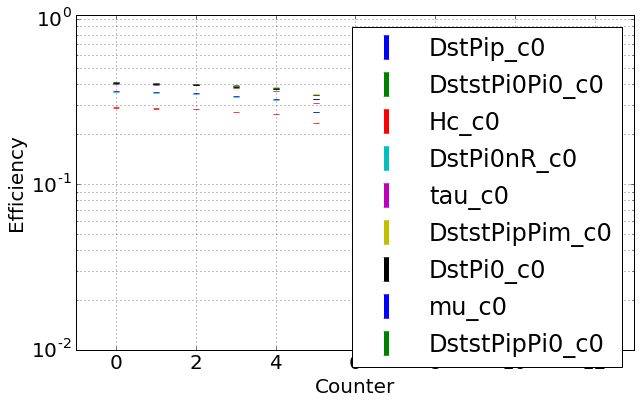

In [16]:
t = PrettyTable()
t.field_names = ['Sample'] + [str(i) for i in range(d.counters.shape[0])]
for n, d in inDic.iteritems():
    eff = np.zeros((d.counters.shape[0], 2))
    eff[0] = d.effCAND_trg
    for i in range(d.counters[1:].shape[0]):
        eff[i+1] = getEff(d.counters[i+1], d.nTotMINIAOD)
    t.add_row([n] + ['{:.2f}'.format(100*e[0]) for e in eff])
    x = np.arange(eff.shape[0])
    p = plt.errorbar(x, eff[:, 0], eff[:,1], lw=0, elinewidth=5, label=n)
    
#     plt.plot(x[[0,-1]], 2*[d.effCAND[0]], '-', color=p[0].get_color())
#     plt.fill_between(x[[0,-1]], 2*[d.effCAND[0]-d.effCAND[1]], 2*[d.effCAND[0]+d.effCAND[1]], color=p[0].get_color(), alpha=0.2)
print t
plt.rcParams.update({'font.size': 20})
plt.xlabel('Counter')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.ylim(0.01,1.05)
plt.xlim(-1, eff.shape[0])
plt.grid(True, which='both')
plt.yscale('log')
plt.gcf().set_size_inches(10, 6)

+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+
|     Sample     |   0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |   10  |   11  |   12   |
+----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+
|   DstPip_c0    | 40.90 | 98.51 | 99.05 | 98.29 | 97.23 | 91.06 | 73.38 | 99.70 | 88.69 | 57.94 | 54.32 | 90.58 | 100.00 |
| DststPi0Pi0_c0 | 41.34 | 98.47 | 99.07 | 96.42 | 96.99 | 86.90 | 75.64 | 99.72 | 88.23 | 56.53 | 52.80 | 90.56 | 100.00 |
|     Hc_c0      | 29.03 | 98.62 | 98.81 | 96.43 | 97.45 | 88.15 | 66.52 | 99.54 | 92.90 | 65.10 | 50.94 | 66.38 | 100.00 |
|  DstPi0nR_c0   | 35.91 | 98.61 | 99.05 | 95.95 | 96.04 | 84.82 | 72.45 | 99.69 | 87.79 | 54.21 | 46.67 | 89.77 | 100.00 |
|     tau_c0     | 40.44 | 98.69 | 99.02 | 95.85 | 96.06 | 85.31 | 72.76 | 99.67 | 87.80 | 55.89 | 49.09 | 79.19 | 100.00 |
| DststP

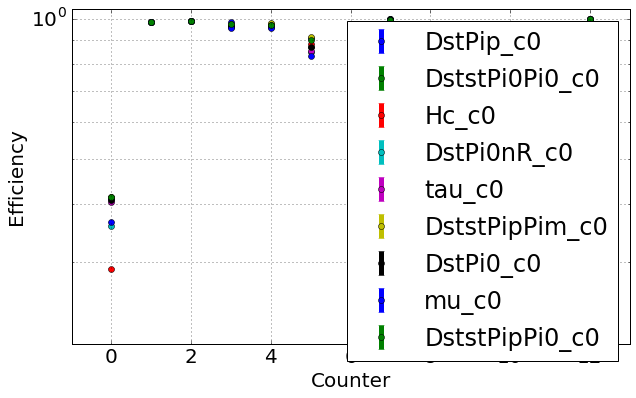

In [17]:
t = PrettyTable()
t.field_names = ['Sample'] + [str(i) for i in range(d.counters.shape[0])]
for n, d in inDic.iteritems():
    eff = np.zeros((d.counters.shape[0], 2))
    eff[0] = d.effCAND_trg
    for i in range(d.counters[1:].shape[0]):
        eff[i+1] = getEff(d.counters[i+1], d.counters[i])
    t.add_row([n] + ['{:.2f}'.format(100*e[0]) for e in eff])
    x = np.arange(eff.shape[0])
    p = plt.errorbar(x, eff[:, 0], eff[:,1], fmt='o', lw=0, elinewidth=5, label=n)
print t
plt.rcParams.update({'font.size': 20})
plt.xlabel('Counter')
plt.ylabel('Efficiency')
plt.legend(loc='best', numpoints=1)
plt.ylim(0.2,1.05)
plt.xlim(-1, eff.shape[0])
plt.grid(True, which='both')
plt.yscale('log')
plt.gcf().set_size_inches(10, 6)